In [25]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.utils.validation import check_is_fitted

In [26]:
# my data
data = pd.read_csv('/home/giwrikas/Downloads/Morphemic_datasets/all-4 (1).csv')
cols = ["memory_alloc","cpu_alloc","cpu_usage","memory","number_instances"]
data[cols] = data[cols].replace({ 0:np.nan})
data = data.dropna(subset=['number_instances', 'memory_alloc','cpu_alloc'])
data = data.drop(columns=['Unnamed: 0'])


In [27]:
# Data Description
data.describe()

,served_request,request_rate,number_instances,response_time,performance,cpu_usage,cpu_alloc,memory,memory_alloc
count,30507.000000,30507.000000,30507.000000,30507.000000,30507.000000,29608.000000,3.050700e+04,2.960900e+04,3.050700e+04
mean,22.391650,12.817522,1.366047,507.126627,61.012755,38.267329,5.318124e+07,3.148796e+07,6.031931e+07
std,63.763675,37.790600,0.790343,2753.332913,41.012945,9.283774,1.058040e+08,6.424793e+06,1.064008e+08
min,0.000000,0.000000,1.000000,0.000000,0.000000,14.866667,2.000000e+00,2.083499e+06,3.200000e+01
25%,0.000000,0.000000,1.000000,0.000000,7.965264,30.700000,2.000000e+00,2.705818e+07,5.600000e+01
50%,1.000000,0.333333,1.000000,1.519786,66.744838,39.233333,2.000000e+00,3.301786e+07,5.600000e+01
75%,22.111111,10.142857,1.000000,7.311278,100.000000,45.433333,7.000000e+00,3.570483e+07,5.600000e+01
max,636.000000,322.000000,5.000000,55029.395103,218.222552,73.400000,4.000000e+08,5.108668e+07,2.480000e+08


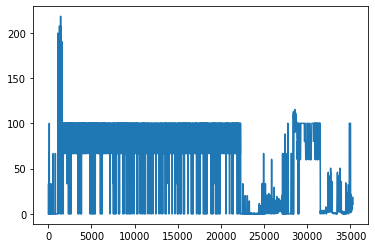

In [66]:
data['performance'].plot()

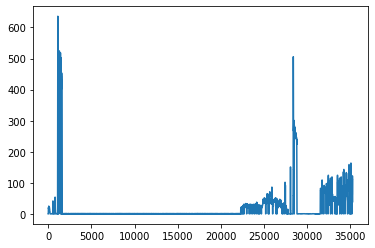

In [78]:
data['served_request'].plot()

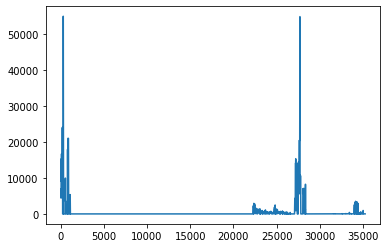

In [31]:
data['response_time'].plot()

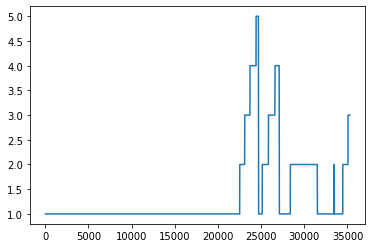

In [19]:
data['number_instances'].plot()

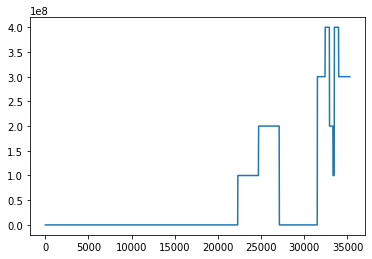

In [20]:
data['cpu_alloc'].plot()

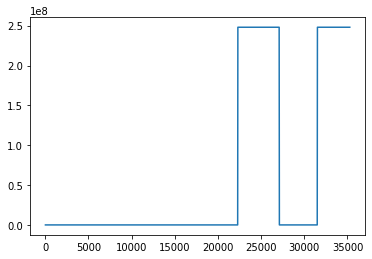

In [21]:
data['memory_alloc'].plot()

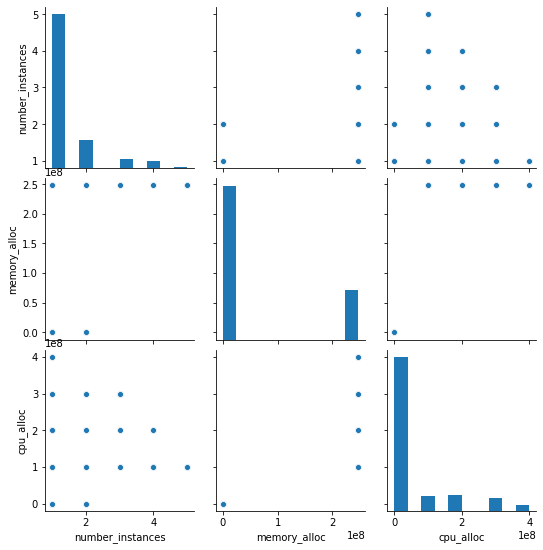

In [23]:
import seaborn as sns
sns.pairplot(data = data, vars=['number_instances','memory_alloc','cpu_alloc'])
plt.show()

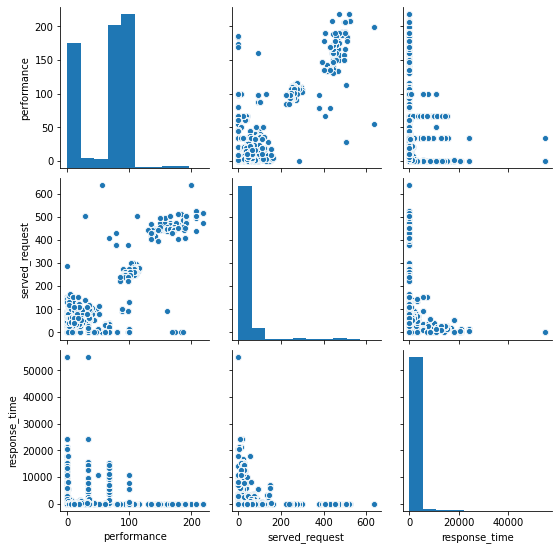

In [24]:
import seaborn as sns
sns.pairplot(data = data, vars=['performance','served_request','response_time'])
plt.show()

### Here we are doing a minor modification at the data in order not to have values like 1000000000.0 (and not to observe very big deviation)

In [28]:
data['cpu_alloc'] = data['cpu_alloc'].replace(100000000.0, 1)
data['cpu_alloc'] = data['cpu_alloc'].replace(200000000.0, 2)
data['cpu_alloc'] = data['cpu_alloc'].replace(300000000.0, 3)
data['cpu_alloc'] = data['cpu_alloc'].replace(400000000.0, 4)

In [29]:
data['memory_alloc'] = data['memory_alloc'].replace(248000000.0, 248)

# Missing Values Imputation 
#### We are using an inheritance from the sklearn.base classes (BaseEstimator, TransformerMixin). 

# Group Data according to configuration and then for each configuration take the mean or the meadian

In [47]:
#Missing Values Imputation 

class GroupImputer(BaseEstimator, TransformerMixin):
    '''
    Class used for imputing missing values in a pd.DataFrame using either mean or median of a group.

    Parameters
    ----------
    group_cols : list
        List of columns used for calculating the aggregated value
    target : str
        The name of the column to impute
    metric : str
        The metric to be used for remplacement, can be one of ['mean', 'median']
    Returns
    -------
    X : array-like
        The array with imputed values in the target column
    '''

    def __init__(self, group_cols, target, metric='mean'):
        assert metric in ['mean', 'median'], 'Unrecognized value for metric, should be mean/median'
        #assert type(group_cols) == list, 'group_cols should be a list of columns'
        assert type(target) == str, 'target should be a string'

        self.group_cols = group_cols
        self.target = target
        self.metric = metric

    def fit(self, X, y=None):
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, 'There are missing values in group_cols'

        impute_map = X.groupby(self.group_cols)[self.target].agg(self.metric).reset_index(drop=False)#
        
        print(impute_map)
        self.impute_map_ = impute_map

        return self

    def transform(self, X, y=None):
        # make sure that the imputer was fitted
        check_is_fitted(self, 'impute_map_')

        X = X.copy()

        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind] = X.loc[ind].fillna(row[self.target])

        return X.values


conf_columns = ['number_instances', 'cpu_alloc', 'memory_alloc' ]

for col_name in data.columns:
    if col_name != 'number_instances' and col_name != 'cpu_alloc' and col_name!= 'memory_alloc' :

        imp = GroupImputer(group_cols=conf_columns,
                           target=col_name,
                           metric='median')

        df_imp = pd.DataFrame(imp.fit_transform(data),
                              columns=data.columns)



for col_name in data.columns:
    if col_name != 'number_instances' and col_name != 'cpu_alloc' and col_name!= 'memory_alloc' :

        print(f'data contains {sum(pd.isnull(data[col_name]))} missing values.')
        print(f'df_imp contains {sum(pd.isnull(df_imp[col_name]))} missing values.')



    number_instances  cpu_alloc  memory_alloc  served_request
0                1.0        1.0         248.0       22.333333
1                1.0        2.0          32.0        0.000000
2                1.0        2.0          48.0      636.000000
3                1.0        2.0          56.0        0.000000
4                1.0        2.0         248.0       44.666667
5                1.0        3.0          32.0        5.000000
6                1.0        3.0         248.0       72.333333
7                1.0        4.0         248.0       90.666667
8                1.0        6.0          32.0       58.333333
9                2.0        1.0         248.0       25.200000
10               2.0        2.0         248.0       46.800000
11               2.0        3.0         248.0       72.400000
12               2.0        6.0          32.0      141.000000
13               2.0        7.0          32.0        0.600000
14               3.0        1.0         248.0       24.285714
15      

In [220]:
df_imp.isna().sum()

served_request      0
request_rate        0
number_instances    0
response_time       0
performance         0
cpu_usage           0
cpu_alloc           0
memory              0
memory_alloc        0
dtype: int64

# Create a dataframe for each configuration, apply KNN missing value imputation and  return a unified dataframe without missing values

# Create a class that returns a list with dataframes. Each DataFrame corresponds to each configuration. *This dataset has 20 unique Configurations*

In [8]:
data_cols = data.columns

def split(df, group_cols):
     gb = df.groupby(group_cols)
     return [gb.get_group(x) for x in gb.groups]

group_cols  = ['number_instances', 'cpu_alloc', 'memory_alloc' ]
data = split(data,group_cols )


## Check in which dataset appears nan values, and how many they are

In [9]:
print(data[0].isna().sum(),
data[1].isna().sum(),
data[2].isna().sum(),
data[3].isna().sum(),
data[4].isna().sum(),
data[5].isna().sum(),
data[6].isna().sum(),
data[7].isna().sum(),
data[8].isna().sum(),
data[9].isna().sum(),
data[10].isna().sum(),
data[11].isna().sum(),
data[12].isna().sum(),
data[13].isna().sum(),
data[14].isna().sum(),
data[15].isna().sum(),
data[16].isna().sum(),
data[17].isna().sum(),
data[18].isna().sum(),
data[19].isna().sum())


served_request      0
request_rate        0
number_instances    0
response_time       0
performance         0
cpu_usage           0
cpu_alloc           0
memory              0
memory_alloc        0
dtype: int64 served_request        0
request_rate          0
number_instances      0
response_time         0
performance           0
cpu_usage           491
cpu_alloc             0
memory              498
memory_alloc          0
dtype: int64 served_request      0
request_rate        0
number_instances    0
response_time       0
performance         0
cpu_usage           0
cpu_alloc           0
memory              0
memory_alloc        0
dtype: int64 served_request       0
request_rate         0
number_instances     0
response_time        0
performance          0
cpu_usage            6
cpu_alloc            0
memory              28
memory_alloc         0
dtype: int64 served_request      0
request_rate        0
number_instances    0
response_time       0
performance         0
cpu_usage          

# Use this loop to try different algorithms for missing values imputation 

In [10]:
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler, IterativeSVD

imputer = KNNImputer(n_neighbors=3)
#imputer = IterativeImputer(random_state=0)

df = pd.DataFrame(columns = data_cols)
list = []
for i in data:
    i = imputer.fit_transform(i)
    #i = BiScaler().fit_transform(i)
    #i = fast_knn(i.values, k=3)
    j = pd.DataFrame(i, columns = data_cols)
    list.append(j)
    df_imp = pd.concat(list, axis=0,  ignore_index=True)
    


Using TensorFlow backend.


## The same below were found somewhere in stackoverflow, I leave them here just in case we need them (in future)

In [16]:
from sklearn.neighbors import KNeighborsRegressor

# function for KNN model-based imputation of missing values using features without NaN as predictors
def impute_model_basic(df):
  cols_nan = df.columns[df.isna().any()].tolist()
  cols_no_nan = df.columns.difference(cols_nan).values
  for col in cols_nan:
      test_data = df[df[col].isna()]
      train_data = df.dropna()
      knr = KNeighborsRegressor(n_neighbors=5).fit(train_data[cols_no_nan], train_data[col])
      df.loc[df[col].isna(), col] = knr.predict(test_data[cols_no_nan])
  return df

df = pd.DataFrame(columns = data_cols)
list = []
for i in data:
    i = impute_model_basic(i)
    list.append(i)
    df_imp = pd.concat(list, axis=0,  ignore_index=True)

In [22]:
def impute_model_progressive(df):
  cols_nan = df.columns[df.isna().any()].tolist()
  cols_no_nan = df.columns.difference(cols_nan).values
  while len(cols_nan)!=0:
      col = cols_nan[0]
      test_data = df[df[col].isna()]
      train_data = df.dropna()
      knr = KNeighborsRegressor(n_neighbors=5).fit(train_data[cols_no_nan], train_data[col])
      df.loc[df[col].isna(), col] = knr.predict(test_data[cols_no_nan])
      cols_nan = df.columns[df.isna().any()].tolist()
      cols_no_nan = df.columns.difference(cols_nan).values
  return df


df = pd.DataFrame(columns = data_cols)
list = []
for i in data:
    i = impute_model_basic(i)
    list.append(i)
    df_imp = pd.concat(list, axis=0,  ignore_index=True)


In [14]:
print(len(df['number_instances'].unique()), 
len(df['memory_alloc'].unique()),
len(df['cpu_alloc'].unique()))

5 4 8


In [12]:
df_imp.describe()

,served_request,request_rate,number_instances,response_time,performance,cpu_usage,cpu_alloc,memory,memory_alloc
count,30507.000000,30507.000000,30507.000000,30507.000000,30507.000000,3.050700e+04,3.050700e+04,3.050700e+04,3.050700e+04
mean,22.391650,12.817522,1.366047,507.126627,61.012755,3.026769e+05,5.318124e+07,3.084896e+07,6.031931e+07
std,63.763675,37.790600,0.790343,2753.332913,41.012945,1.997972e+06,1.058040e+08,7.355335e+06,1.064008e+08
min,0.000000,0.000000,1.000000,0.000000,0.000000,1.486667e+01,2.000000e+00,2.083499e+06,3.200000e+01
25%,0.000000,0.000000,1.000000,0.000000,7.965264,3.090000e+01,2.000000e+00,2.610790e+07,5.600000e+01
50%,1.000000,0.333333,1.000000,1.519786,66.744838,3.963333e+01,2.000000e+00,3.294140e+07,5.600000e+01
75%,22.111111,10.142857,1.000000,7.311278,100.000000,4.580000e+01,7.000000e+00,3.570483e+07,5.600000e+01
max,636.000000,322.000000,5.000000,55029.395103,218.222552,3.953736e+07,4.000000e+08,5.108668e+07,2.480000e+08


## Data Normalization

In [49]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
#afp = np.append(X_train.values, X_test.values, axis=0)
std.fit(df_imp)

#X_train = std.transform(X_train)
#X_test = std.transform(X_test)
df_imp_norm = std.transform(df_imp)
df_imp_norm = pd.DataFrame(df_imp_norm, columns = df_imp.columns)


## Correlation Heatmap

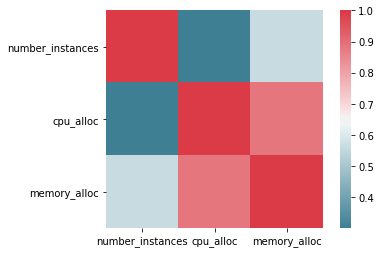

In [152]:
import seaborn as sns
corr = X_train.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)

## Polynomial Features Creation

In [52]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True)
output_nparray = poly.fit_transform(df_imp_norm.drop(columns=['performance', 
                                                     'served_request',
                                'request_rate', 'response_time', 'memory' , 
                                                'number_instances','cpu_usage'
                                                                  ]))
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(df_imp_norm.columns, p) for p in poly.powers_]]
output_df = pd.DataFrame(output_nparray, columns=target_feature_names)

In [33]:
output_df = output_df.drop(columns=[''])


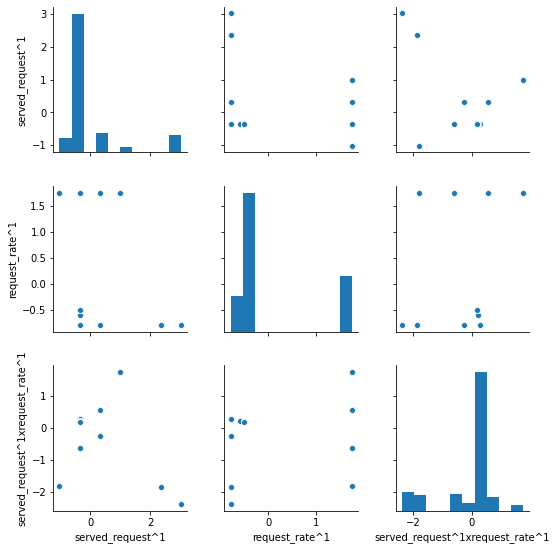

In [46]:
import seaborn as sns
sns.pairplot(data = output_df, vars=output_df.columns)
plt.show()

In [35]:
# Decision Tree Regressor for the 1rst Model which uses the configuration variables in order to predict the performance (variable)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
X_train, X_test, y_train, y_test = train_test_split(output_df,
                                                    df_imp['performance'],random_state=0)
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
cross_val_score(regressor, X_train, y_train, cv=10)
pred = regressor.predict(X_test)
print(r2_score(y_test, pred))

0.7656269059816233


# Algorithms Experimentation

## Decision Tree Regressor (Model 1)

#### 1) Tι συμβαινει αν απλα πεταξω ολες τις γραμμες που εχουν nan values

In [15]:
## Decision Tree Regressor for the  Model which uses the configuration variables in order to predict the performance (variable)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

data_2 = data.dropna()

X_train, X_test, y_train, y_test = train_test_split(data_2.drop(columns=['performance', 'served_request',
                                                                        'request_rate', 'response_time', 'memory' , 'cpu_usage'
                                                                  ]),
                                                    data_2['performance'],random_state=0)
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
cross_val_score(regressor, X_train, y_train, cv=10)
pred = regressor.predict(X_test)
print(r2_score(y_test, pred))
print(mean_squared_error(y_test, pred, squared=True))
print(mean_squared_error(y_test, pred, squared=False))


0.7517355870686013
405.9587839513277
20.14841889457651


#### 2) Έχοντας κάνει missing values imputation με mean η median

In [48]:
X_train, X_test, y_train, y_test = train_test_split(df_imp.drop(columns=['performance', 'served_request',
                                                                        'request_rate', 'response_time', 'memory' , 'cpu_usage'
                                                                  ]),
                                                    df_imp['performance'],random_state=0)
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
cross_val_score(regressor, X_train, y_train, cv=10)
pred = regressor.predict(X_test)
print(r2_score(y_test, pred))
print(mean_squared_error(y_test, pred, squared=True))
print(mean_squared_error(y_test, pred, squared=False))

0.7692254929747864
385.943180458257
19.64543663190658


#### 3) Έχοντας κάνει missing values imputation με mean η median και μετα normalization

In [50]:
X_train, X_test, y_train, y_test = train_test_split(df_imp_norm.drop(columns=['performance', 'served_request',
                                                                        'request_rate', 'response_time', 'memory' , 'cpu_usage'
                                                                  ]),
                                                    df_imp_norm['performance'],random_state=0)
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
cross_val_score(regressor, X_train, y_train, cv=10)
pred = regressor.predict(X_test)
print(r2_score(y_test, pred))
print(mean_squared_error(y_test, pred, squared=True))
print(mean_squared_error(y_test, pred, squared=False))

0.7692254929747863
0.2294540335305468
0.47901360474473664


#### 4) Με δημιουργία polynomial features έχωντας κάνει πριν και  normalization

In [53]:

X_train, X_test, y_train, y_test = train_test_split(output_df,
                                                    df_imp['performance'],random_state=0)
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
cross_val_score(regressor, X_train, y_train, cv=10)
pred = regressor.predict(X_test)
print(r2_score(y_test, pred))
print(mean_squared_error(y_test, pred, squared=True))
print(mean_squared_error(y_test, pred, squared=False))


0.7656269059816233
391.96139333280706
19.798014883639397


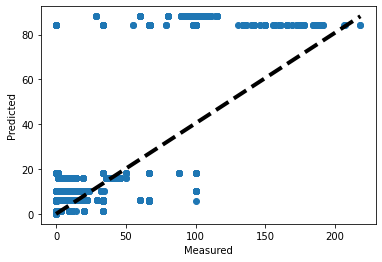

In [54]:

fig, ax = plt.subplots()
ax.scatter(y_test, pred)
ax.plot([y_test.min(), y_test.max()], [pred.min(), pred.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

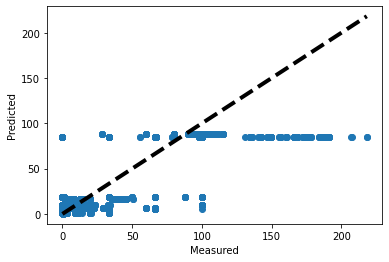

In [55]:
from sklearn.model_selection import cross_val_predict
predicted = cross_val_predict(regressor, X_train, y_train, cv=10)
fig, ax = plt.subplots()
ax.scatter(y_test, pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

#### Hyperparameter Tuning

In [43]:
from  sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 

scoring = make_scorer(r2_score)
g_cv = GridSearchCV(DecisionTreeRegressor(random_state=0),scoring=scoring,
              param_grid={'min_samples_split': range(2, 10), 
                          'criterion' :('mse', 'friedman_mse', 'mae'),
                         'max_depth':range(1,5)},
               cv=5, refit=True)

g_cv.fit(X_train, y_train)
g_cv.best_params_

result = g_cv.cv_results_
# print(result)
r2_score(y_test, g_cv.best_estimator_.predict(X_test))

0.7597725014505193

#### Regressor, AdaBoostRegressor

In [212]:
# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor


# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300)

regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

# Predict
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

cross_val_score(regr_1, X_train, y_train, cv=10)
pred = regressor.predict(X_test)
print(r2_score(y_test, pred))
print(mean_squared_error(y_test, pred, squared=True))

cross_val_score(regr_2, X_train, y_train, cv=10)
pred = regressor.predict(X_test)
print(r2_score(y_test, pred))
print(mean_squared_error(y_test, pred, squared=True))





0.7517355870686013
405.9587839513277
0.7517355870686013
405.9587839513277


# Use a stacking regressor. I have chosen 3 different algorithms but it can be any algorithm (that it can be used for regression). Unfortunatelly this technique does not improve the results. 

In [20]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline

"""lasso_pipeline = make_pipeline(processor_lin,
                               LassoCV())

rf_pipeline = make_pipeline(processor_nlin,
                            RandomForestRegressor(random_state=42))

gradient_pipeline = make_pipeline(
    processor_nlin,
    HistGradientBoostingRegressor(random_state=0))"""

estimators = [('Random Forest', RandomForestRegressor(random_state=42)),
              ('Lasso', LassoCV()),
              ('Gradient Boosting', HistGradientBoostingRegressor(random_state=0))]

stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

stacking_regressor.fit(X_train, y_train)
cross_val_score(stacking_regressor, X_train, y_train, cv=10)
pred = stacking_regressor.predict(X_test)
print(r2_score(y_test, pred))

0.7549909968858104


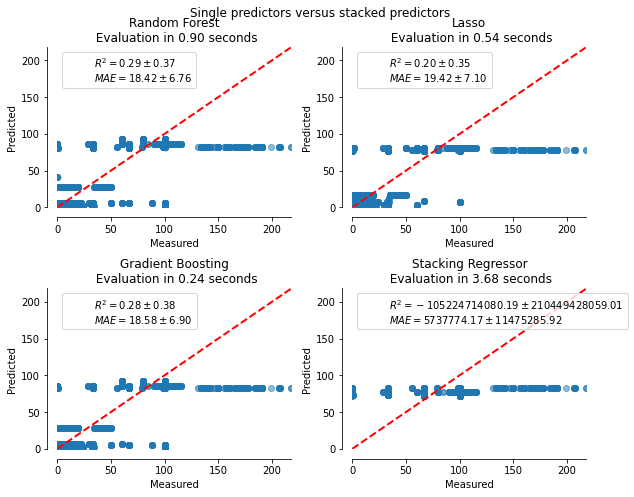

In [25]:
X = df.drop(columns=['performance', 'served_request','request_rate', 'response_time', 'memory' , 'cpu_usage'])
y = df['performance']
            
            
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict


def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    score = cross_validate(est, X, y,
                           scoring=['r2', 'neg_mean_absolute_error'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)

    plot_regression_results(
        ax, y, y_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2']),
                -np.mean(score['test_neg_mean_absolute_error']),
                np.std(score['test_neg_mean_absolute_error'])),
        elapsed_time)

plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Plot the target variable which is "Performance" in our case. Each plot has "performance" at y axis and the other variables of the dataset in x axis.

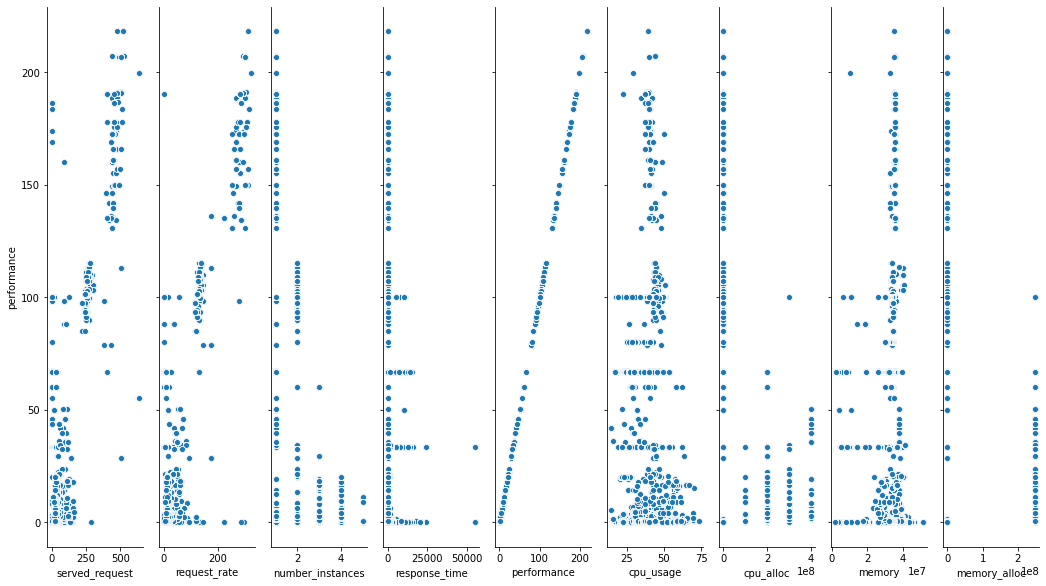

In [41]:
import seaborn as sns
sns.pairplot(df, y_vars="performance", x_vars=df.columns.values,height=8, aspect=0.2)


 ## Decision Tree Visualization 

  #### *Be Carefull* with this because it will make your laptop extremly slow 

In [ ]:
tree.plot_tree(regressor)
plt.figure()
plot_tree(regressor, filled=True)
plt.show()

### Decission Tree Regressor (for served_request and response_time prediction)

In [246]:
### Decision Tree for the 2nd Model which uses metric variables as covariates and make predictions for performance variable

X_train, X_test, y_train, y_test = train_test_split(df_imp.drop(columns=['served_request','performance', 'request_rate','response_time',
                                                                         'cpu_usage','memory' ]),
                                                    df_imp[['served_request', 'response_time']],random_state=1)
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
cross_val_score(regressor, X_train, y_train, cv=10)
pred = regressor.predict(X_test)
print(r2_score(y_test, pred))

0.20745132412777062


/home/giwrikas/anaconda3/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/giwrikas/anaconda3/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput=

/home/giwrikas/anaconda3/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


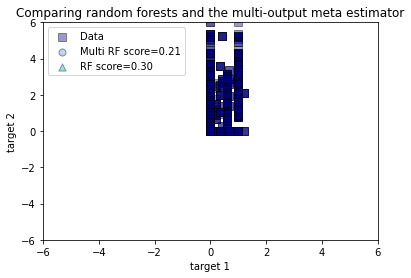

0.20597172204875902
2694447.877936155
0.20487255806047
2692944.922235904


In [253]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor


max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)

regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth,
                                random_state=2)
regr_rf.fit(X_train, y_train)

# Predict on new data
y_multirf = regr_multirf.predict(X_test)
y_rf = regr_rf.predict(X_test)

# Plot the results
plt.figure()
s = 50
a = 0.4
plt.scatter(y_test.values[:, 0], y_test.values[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
plt.scatter(y_multirf[:, 0], y_multirf[:, 1], edgecolor='k',
            c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % regr_multirf.score(X_test, y_test))
plt.scatter(y_rf[:, 0], y_rf[:, 1], edgecolor='k',
            c="c", s=s, marker="^", alpha=a,
            label="RF score=%.2f" % regr_rf.score(X_test, y_test))
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.xlabel("target 1")
plt.ylabel("target 2")
plt.title("Comparing random forests and the multi-output meta estimator")
plt.legend()
plt.show()

#cross_val_score(regr_multirf, X_train, y_train, cv=10)
pred = regr_multirf.predict(X_test)
print(r2_score(y_test, pred))
print(mean_squared_error(y_test, pred, squared=True))

#cross_val_score(regr_rf, X_train, y_train, cv=10)
pred = regr_rf.predict(X_test)
print(r2_score(y_test, pred))
print(mean_squared_error(y_test, pred, squared=True))

#### Again you can visualize your results (ehen using DecisionTreeRegressor)

In [ ]:
tree.plot_tree(regressor)
plt.figure()
plot_tree(regressor, filled=True)
plt.show()

## Random Forest (Model 1)

In [165]:
## Random Forest for 1st Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
regr = RandomForestRegressor(random_state=0)
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
print(r2_score(y_test, pred))

0.7597450071460121


## Gradient Boosting Regressor (Model 1)

In [167]:
## Gradient Boosting Regressor (Metrics as covariates and try to predict performance)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
regr = GradientBoostingRegressor(**params)
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['performance', 'served_request',
                                                                        'request_rate', 'response_time', 'memory' , 'cpu_usage']),
                                                    df['performance'],random_state=0)
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
print(r2_score(y_test, pred))
mse = mean_squared_error(y_test, regr.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

0.7665096356507906
The mean squared error (MSE) on test set: 389.5436


### Plot Deviance

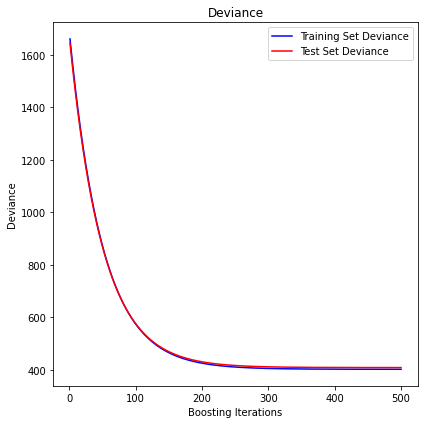

In [21]:
#Plot training Deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, pred in enumerate(regr.staged_predict(X_test)):
    test_score[i] = regr.loss_(y_test, pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, regr.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

## Plot Feature Importances

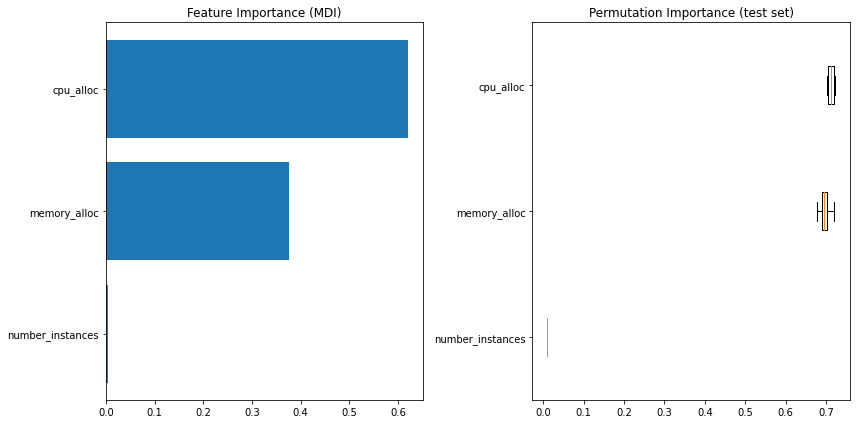

In [22]:
#Plot feature importances
from sklearn.inspection import permutation_importance
feature_importance = regr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(regr, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_train.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## Voting Regressor (Model 1)

In [37]:
##Voting Regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
# Training Regressors
reg1 = GradientBoostingRegressor(random_state=0, n_estimators=10)
reg2 = RandomForestRegressor(random_state=0, n_estimators=10)
reg3 = DecisionTreeRegressor()
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
X_train, X_test, y_train, y_test = train_test_split(df_imp.drop(columns=['performance', 'served_request',
                                                                        'request_rate', 'response_time', 'memory' , 'cpu_usage']),
                                                    df_imp['performance'],random_state=1)
ereg = ereg.fit(X_train, y_train)
pred = ereg.predict(X_test)
print(r2_score(y_test, pred))

0.7446030377477983


# Try to predict performance *without using missing value imputation* technique (only drop all rows with at least one nan value)

In [57]:
data = pd.read_csv('/home/giwrikas/Downloads/Morphemic_datasets/all-4 (1).csv')
cols = ["memory_alloc","cpu_alloc","cpu_usage","memory","number_instances"]
data[cols] = data[cols].replace({ 0:np.nan})
data.isna().sum()

Unnamed: 0             0
served_request         0
request_rate           0
number_instances    2813
response_time          0
performance            0
cpu_usage           3737
cpu_alloc           2759
memory              3692
memory_alloc        3031
dtype: int64

In [58]:
data = data.dropna()
data.isna().sum()

Unnamed: 0          0
served_request      0
request_rate        0
number_instances    0
response_time       0
performance         0
cpu_usage           0
cpu_alloc           0
memory              0
memory_alloc        0
dtype: int64

## Model 1

In [60]:
## Decision Tree Regressor for the 1rst Model which uses the configuration variables in order to predict the performance (variable)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['performance', 'served_request',
                                                                        'request_rate', 'response_time', 'memory' , 'cpu_usage']),
                                                    data['performance'],random_state=1)
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
cross_val_score(regressor, X_train, y_train, cv=10)
pred = regressor.predict(X_test)
print(r2_score(y_test, pred))
print(mean_squared_error(y_test, pred))

0.950551041216221
79.5004816722087
